# 媒体情绪对分析师情绪的影响

## 1.数据准备
风险偏好
事件

In [1]:
import sys
import os
import numpy as np
import cudf  #CUDA计算
import pandas as pd

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')


# 多核 groupby Apply
from pandarallel import pandarallel

# 数据库
from utils.sql import DB

from loader.findata_loader import DownLoader
from loader.findata_loader import Loader

# 统计工具
from statsmodels.regression.rolling import RollingOLS  #滚动回归
from statsmodels.regression.linear_model import OLS  #OLS回归

# Stata
from pystata import config

config.init('mp')

# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


### 1.1 下载和合并面板数据

In [2]:
# 数据集:个股K线面板数据,个股基本面数据
DownLoader().load_data()

data_loader = Loader()

0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
0it [00:00, ?it/s]


#### 指数盈利预测面板数据

In [3]:
data_loader.get_conidx_panel()

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
trade_date ts_code                                                    
20131231   000002.SH      2013  2.150299e+09  1.996171e+08   0.6183   
           000010.SH      2013  1.616497e+09  1.803029e+08   0.7227   
           000015.SH      2013  9.223393e+08  1.402562e+08   0.7359   
           000016.SH      2013  1.095701e+09  1.190502e+08   0.7747   
           000067.SH      2013  1.304862e+08  7.875350e+06   0.5807   
...                        ...           ...           ...      ...   
20221028   399312.SZ      2022  3.583564e+09  3.023053e+08   1.1050   
           399313.SZ      2022  2.848629e+09  3.164494e+08   1.1574   
           399317.SZ      2022  7.321688e+09  5.934493e+08   0.7403   
           000985.SH      2022  7.224144e+09  5.840384e+08   0.7555   
           000688.SH      2022  6.009689e+07  7.351126e+06   1.0083   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
trade_date ts_code                                                              
20131231   000002.SH  1.407965e+09  1.2913  0.8455   9.1078   0.5689    14.18   
           000010.SH  1.156060e+09  1.1894  0.8506   7.6264   0.5842    15.60   
           000015.SH  8.384264e+08  1.0141  0.9219   6.0624   0.5667    16.73   
           000016.SH  7.548906e+08  1.1679  0.8046   7.4054   0.5799    15.77   
           000067.SH  6.214941e+07  2.2588  1.0758  17.8255   0.9922    12.67   
...                            ...     ...     ...      ...      ...      ...   
20221028   399312.SZ  2.454648e+09  1.4467  0.9909  11.7465   0.7619    12.32   
           399313.SZ  2.754211e+09  0.9901  0.9572   8.6169   0.7773    11.49   
           399317.SZ  5.905421e+09  1.2950  1.0445  12.8868   0.7655    10.05   
           000985.SH  5.825681e+09  1.3191  1.0637  13.1574   0.7802    10.03   
           000688.SH  6.128843e+07  4.1037  4.1850  34.2135   0.9417    11.99   

                      CON_OR_YOY  CON_NP_YOY  CON_NPCGRATE_2Y  CON_PEI  
trade_date ts_code                                                      
20131231   000002.SH        9.89       18.25          16.0105  78.4365  
           000010.SH        8.21       13.78          13.0548  80.9011  
           000015.SH        5.53       11.24          10.6985  83.8420  
           000016.SH        7.24       13.37          12.7691  81.7573  
           000067.SH       12.46       16.76          17.9659  61.4964  
...                          ...         ...              ...      ...  
20221028   399312.SZ       15.04       15.51          15.4183  94.5570  
           399313.SZ       14.36       10.80          11.0863  94.4014  
           399317.SZ       10.82       15.55          16.8354  80.5216  
           000985.SH       10.96       15.11          16.8637  80.1858  
           000688.SH       43.95       46.41          36.3298  98.5569  

[43510 rows x 14 columns]

#### A股基本面面板数据

In [4]:
data_loader.get_ashare_panel()

open     high      low    close  pre_close  change  \
trade_date ts_code                                                            
20140102   000001.SZ   6.2109   6.3032   6.1751   6.2673     6.2776 -0.0103   
           000002.SZ   5.4033   5.4574   5.3559   5.4033     5.4303 -0.0270   
           000004.SZ  11.6400  11.8700  11.4500  11.8100    11.6500  0.1600   
           000005.SZ   2.5000   2.5200   2.4700   2.4900     2.5000 -0.0100   
           000006.SZ   3.8968   3.9047   3.8256   3.8494     3.8968 -0.0474   
...                       ...      ...      ...      ...        ...     ...   
20221130   872374.BJ   9.7300   9.8100   9.6500   9.6800     9.8500 -0.1700   
20221201   301290.SZ  49.8100  51.4900  47.9400  48.4800    53.1200 -4.6400   
           301311.SZ  20.4000  24.2800  20.1600  22.5600    20.0100  2.5500   
           870199.BJ  29.0000  30.8000  28.1800  30.8000    31.8000 -1.0000   
           872374.BJ   9.6300   9.7500   9.6300   9.7000     9.6800  0.0200   

                      share_return        vol       amount turnover_rate  ...  \
trade_date ts_code                                                        ...   
20140102   000001.SZ       -0.1641  489910.89  596223.7444        0.8786  ...   
           000002.SZ       -0.4972  485299.22  387391.0664        0.5016  ...   
           000004.SZ        1.3734    9714.74   11417.5556        1.1582  ...   
           000005.SZ       -0.4000   29997.74    7473.5909        0.3283  ...   
           000006.SZ       -1.2164   88230.28   43051.9277        0.6604  ...   
...                            ...        ...          ...           ...  ...   
20221130   872374.BJ       -1.7259    8135.76    7893.3140          <NA>  ...   
20221201   301290.SZ       -8.7349  108843.32  534442.0180       48.0937  ...   
           301311.SZ       12.7436  342502.29  750712.7690       60.1845  ...   
           870199.BJ       -3.1447   33555.95   97293.8040         28.93  ...   
           872374.BJ        0.2066    4895.79    4744.5780          <NA>  ...   

                           pb       ps   ps_ttm dv_ratio  dv_ttm  total_share  \
trade_date ts_code                                                              
20140102   000001.SZ   1.0563   2.5222   2.1079   0.8688  0.8688  819736.0665   
           000002.SZ   1.2891   0.8534   0.7309   2.2509  2.2509  1101372.497   
           000004.SZ  12.6589  10.1862   9.4261      0.0    <NA>    8397.6684   
           000005.SZ    3.486  22.8994  26.6946      0.0    <NA>   91433.3607   
           000006.SZ    1.749   2.1372   2.4689   1.9556  1.9556  134999.5046   
...                       ...      ...      ...      ...     ...          ...   
20221130   872374.BJ     <NA>     <NA>     <NA>     <NA>    <NA>         <NA>   
20221201   301290.SZ   2.2424  10.8767  10.6376     <NA>    <NA>   10017.3334   
           301311.SZ   3.1221   2.8278   2.8627     <NA>    <NA>      24000.0   
           870199.BJ   2.7135   4.5536   3.7651     <NA>    <NA>       4865.0   
           872374.BJ     <NA>     <NA>     <NA>     <NA>    <NA>         <NA>   

                      float_share   free_share     total_mv      circ_mv  
trade_date ts_code                                                        
20140102   000001.SZ  557590.1875  390867.8851  10025372.09  6819327.993  
           000002.SZ   967494.124  805584.6474   8799966.25  7730278.051  
           000004.SZ    8387.5459    6196.0792   99176.4638   99056.9171  
           000005.SZ   91374.3007   72950.2562  227669.0681  227522.0087  
           000006.SZ  133595.2936   65409.8872  657447.5874  650609.0798  
...                           ...          ...          ...          ...  
20221130   872374.BJ         <NA>         <NA>         <NA>         <NA>  
20221201   301290.SZ    2263.1536    2263.1536  485640.3232  109717.6865  
           301311.SZ    5690.8675    5690.8675     541440.0  128385.9708  
           870199.BJ       1159.9       1159.9     149842.0     

#### 指数基本面面板数据

In [5]:
data_loader.get_index_panel()

close        open        high         low  \
trade_date ts_code                                                     
20140102   000001.SH    2109.387    2112.126     2113.11    2101.016   
           000016.SH    1561.099    1570.049    1570.049    1553.476   
           000300.SH    2321.978    2323.433    2325.991    2310.653   
           000905.SH    3847.879    3823.316    3848.253    3813.806   
           399001.SZ    8114.388    8083.772    8124.558    8048.274   
...                          ...         ...         ...         ...   
20221207   000016.SH    2670.647   2678.6369   2705.2434   2661.2477   
           000300.SH   3958.4409   3956.6722   3999.5864   3944.1831   
           000905.SH   6204.0051   6198.0532   6243.9022   6183.3338   
           399001.SZ  11418.7632  11365.9813  11504.3936  11358.6814   
           399300.SZ        <NA>        <NA>        <NA>        <NA>   

                       pre_close    change shareindex_return          vol  \
trade_date ts_code                                                          
20140102   000001.SH    2115.978    -6.591           -0.3115   68485486.0   
           000016.SH    1574.781   -13.682           -0.8688   15725481.0   
           000300.SH    2330.026    -8.048           -0.3454   45194291.0   
           000905.SH    3829.096    18.783            0.4905   30800260.0   
           399001.SZ    8121.788      -7.4           -0.0911  76523675.97   
...                          ...       ...               ...          ...   
20221207   000016.SH   2684.8458  -14.1988           -0.5288   34532578.0   
           000300.SH   3968.1979    -9.757           -0.2459  143001356.0   
           000905.SH   6211.2515   -7.2464           -0.1167  137821246.0   
           399001.SZ  11398.8201   19.9431             0.175  445500812.0   
           399300.SZ        <NA>      <NA>              <NA>         <NA>   

                           amount      total_mv      float_mv   total_share  \
trade_date ts_code                                                            
20140102   000001.SH  61921354.65  1.816591e+13  1.355083e+13  3.233397e+12   
           000016.SH  14982557.38  8.764339e+12  7.067457e+12  1.536462e+12   
           000300.SH  49012211.12  1.724706e+13  1.263173e+13  2.880502e+12   
           000905.SH  31417807.02  3.684081e+12  2.879294e+12  4.173544e+11   
           399001.SZ  95994236.32  1.809932e+12  1.331610e+12  1.431701e+11   
...                           ...           ...           ...           ...   
20221207   000016.SH  64178141.48  1.798471e+13  1.500842e+13  1.586560e+12   
           000300.SH  255490829.0  4.800432e+13  3.634145e+13  4.012892e+12   
           000905.SH  155238837.7  1.237585e+13  1.067164e+13  1.360448e+12   
           399001.SZ  546530031.6  2.251881e+13  1.857781e+13  1.292449e+12   
           399300.SZ         <NA>  4.800432e+13  3.634145e+13  4.012892e+12   

                       float_share    free_share  turnover_rate  \
trade_date ts_code                                                
20140102   000001.SH  2.358476e+12  7.076779e+11           0.29   
           000016.SH  1.244444e+12  2.652202e+11           0.13   
           000300.SH  2.067522e+12  5.658356e+11           0.22   
           000905.SH  3.399529e+11  1.950857e+11           0.91   
           399001.SZ  1.126513e+11  7.292581e+10           0.64   
...                            ...           ...            ...   
20221207   000016.SH  1.232971e+12  3.381492e+11           0.28   
           000300.SH  2.885259e+12  1.092071e+12           0.50   
           000905.SH  1.181857e+12  6.334603e+11           1.17   
           399001.SZ  1.093008e+12  6.351503e+11           1.19   
           399300.SZ  2.885259e+12  1.092071e+12           0.50   

                      turnover_rate_f     pe  pe_ttm    pb  
trade_date ts_code                                          
20140102   000001.SH             0.96  10.71    9.64  1.34  
     

#### 时间序列数据

In [6]:
data_loader.get_time_series()

,img_neg,tex_neg,riskfree_return
trade_date,,,
20140102,0.0,0.0,0.015460
20140103,0.0,0.333333,0.015461
20140106,0.285714,0.142857,0.015481
20140107,0.0,0.333333,0.015489
20140108,0.333333,0.0,0.015506
...,...,...,...
20221125,<NA>,<NA>,0.006078
20221128,<NA>,<NA>,0.006069
20221129,<NA>,<NA>,0.006072


## 2.多群体视角下的情绪分析

#### 计算分析师偏离指标

In [7]:
def merge_profit_con_basic():
    """
    合并指数基本面,一致预期,利润数据
    :return:
    """
    # 用于计算的数据

    df_idx_con = data_loader.get_conidx_panel().reset_index()
    df_profit = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_PROFIT.parquet').reset_index()

    # 指数基本面板数据计算
    df_idx_con['trade_year'] = df_idx_con['trade_date'] // 10000

    # 利润数据
    df_profit = df_profit.groupby(by=['trade_year', 'ts_code'], as_index=False, ).first()
    df_profit['year_profit_l1'] = df_profit.groupby(by=['ts_code'], as_index=False, sort=True)['year_profit'].shift(1)

    # yoy
    df_profit['year_profit_yoy'] = 100 * ((df_profit['year_profit'] / df_profit['year_profit_l1']) - 1)

    # 基本面表
    df_basic = cudf.read_parquet(f'{DATASETS_PATH}IDX_PANEL_BASIC_WUGUI.parquet').reset_index()
    df_basic['total_mv_l1'] = df_basic.groupby(by=['ts_code'], as_index=False, sort=True)['total_mv'].shift(1)
    df_basic['total_mv_chg'] = 100 * ((df_basic['total_mv'] / df_basic['total_mv_l1']) - 1)

    # 合并
    df_merge = (
            cudf.merge(
                    cudf.merge(df_idx_con, df_profit, on=['trade_year', 'ts_code'], how='left', sort=True),
                    df_basic,
                    on=['trade_date', 'ts_code'], how='left', sort=True
            )
    )

    return df_merge.dropna(axis=0)


merge_profit_con_basic().set_index(['ts_code', 'trade_date']).sort_index().to_pandas()

CON_YEAR        CON_OR        CON_NP  CON_EPS  \
ts_code   trade_date                                                  
000010.SH 20131231        2013  1.616497e+09  1.803029e+08   0.7227   
          20140102        2014  1.229380e+09  2.013905e+08   0.8059   
          20140103        2014  1.229019e+09  2.014236e+08   0.8060   
          20140106        2014  1.228354e+09  2.012950e+08   0.8054   
          20140107        2014  1.223457e+09  2.010169e+08   0.8043   
...                        ...           ...           ...      ...   
399310.SZ 20221024        2022  1.521295e+09  1.557310e+08   1.3769   
          20221025        2022  1.522826e+09  1.557090e+08   1.3767   
          20221026        2022  1.522188e+09  1.556452e+08   1.3761   
          20221027        2022  1.520270e+09  1.548215e+08   1.3688   
          20221028        2022  1.525638e+09  1.543006e+08   1.3643   

                            CON_NA  CON_PB  CON_PS   CON_PE  CON_PEG  CON_ROE  \
ts_code   trade_date                                                            
000010.SH 20131231    1.156060e+09  1.1894  0.8506   7.6264   0.5842    15.60   
          20140102    1.356969e+09  1.0078  0.7662   6.7909   0.5332    14.84   
          20140103    1.357287e+09  0.9952  0.7572   6.7063   0.5262    14.84   
          20140106    1.357130e+09  0.9838  0.7486   6.6330   0.5219    14.83   
          20140107    1.356864e+09  0.9816  0.7487   6.6260   0.5246    14.81   
...                            ...     ...     ...      ...      ...      ...   
399310.SZ 20221024    1.157734e+09  1.4518  1.1049  10.7930   0.8422    13.45   
          20221025    1.157755e+09  1.4487  1.1014  10.7717   0.8464    13.45   
          20221026    1.157994e+09  1.4521  1.1047  10.8033   0.8501    13.44   
          20221027    1.154642e+09  1.4395  1.0933  10.7354   0.8510    13.41   
          20221028    1.151031e+09  1.4075  1.0619  10.4997   0.8521    13.41   

                      ...  pb_ttm_weight  pb_ttm_equal  div_rate    roe  \
ts_code   trade_date  ...                                                 
000010.SH 20131231    ...           1.24          1.90    3.6667  15.82   
          20140102    ...           1.23          1.90    3.6857  15.82   
          20140103    ...           1.21          1.86    3.7325  15.82   
          20140106    ...           1.20          1.79    3.7825  15.82   
          20140107    ...           1.20          1.81    3.7860  15.82   
...                   ...            ...           ...       ...    ...   
399310.SZ 20221024    ...           1.56          3.58    2.8857  13.30   
          20221025    ...           1.55          3.43    2.8301  13.35   
          20221026    ...           1.56          3.38    2.8216  13.39   
          20221027    ...           1.54          3.43    2.8583  13.34   
          20221028    ...           1.50          3.33    2.9328  13.40   

                      profit_avg   mv_avg   float_mv   total_mv  total_mv_l1  \
ts_code   trade_date                                                           
000010.SH 20131231         98.33   768.67  100047.11  136823.66    135377.70   
          20140102         98.33   764.48   99561.25  136077.26    136823.66   
          20140103         98.33   754.84   98313.66  134361.17    136077.26   
          20140106         98.33   746.28   97112.08  132838.33    134361.17   
          20140107         98.33   744.52   97002.79  132525.04    132838.33   
...                          ...      ...        ...        ...          ...   
399310.SZ 20221024        286.93  3361.84  140653.69  168091.78    173613.12   
          20221025        288.27  3354.74  140297.36  167736.80    168091.78   
          20221026        289.54  3363.17  140721.14  168158.26    167736.80   
          20221027        288.64  3324.34  138929.63  166216.95    168158.26   
          20221028        290.29  3240.63  135486.47  162031.73    166216.95   

                      total

In [72]:

# 筛选 +控制变量
df_analyst = merge_profit_con_basic().set_index(['trade_date', 'ts_code']).sort_index()

# 计算偏离
df_analyst['opt_profit_yoy'] = ((df_analyst['CON_NP_YOY'] - df_analyst['year_profit_yoy']) / df_analyst['year_profit_yoy'].abs()) * 100
df_analyst['opt_pe'] = ((df_analyst['CON_PE'] - df_analyst['year_pe_ttm']) / df_analyst['year_pe_ttm'].abs()) * 100
df_analyst['CON_NP'] = df_analyst['CON_NP'] / 10000
df_analyst['opt_profit'] = ((df_analyst['CON_NP'] - df_analyst['year_profit']) / df_analyst['year_profit'].abs()) * 100
df_analyst['total_mv'] = df_analyst['total_mv'] / 10000
# 合并情绪指标
df_analyst_ols = (
        cudf.merge(df_analyst.reset_index(),
                   data_loader.get_time_series().reset_index(), how='left', on='trade_date'
                   ).set_index(['trade_date', 'ts_code', ], ).sort_index().dropna(axis=0).reset_index()
)
# 计算组中日期
df_analyst_ols['time'] = df_analyst_ols.groupby(by=['ts_code'])['trade_date'].rank()
df_analyst_ols = df_analyst_ols.to_pandas().astype(dtype={"trade_date": "str"})

# df_analyst_ols.to_csv(f'{DATASETS_PATH}TEMP.csv')

# # 增加日期虚拟变量
# def add_dummy_column(df, column: str):
#     # df_weekday = pd.get_dummies(pd.to_datetime(df[column], format='%Y%m%d').dt.weekday, prefix='weekday', drop_first=True)
#     df_year = pd.get_dummies(pd.to_datetime(df[column], format='%Y%m%d').dt.year, prefix='year', drop_first=True)
#     return pd.concat([df, df_year], axis=1)


# df_analyst_ols = add_dummy_column(df_analyst_ols, 'trade_date')
df_analyst_ols
# @formatter:off

,trade_date,ts_code,CON_YEAR,CON_OR,CON_NP,CON_EPS,CON_NA,CON_PB,CON_PS,CON_PE,...,total_mv,total_mv_l1,total_mv_chg,opt_profit_yoy,opt_pe,opt_profit,img_neg,tex_neg,riskfree_return,time
0,20140102,000010.SH,2014,1.229380e+09,20139.051805,0.8059,1.356969e+09,1.0078,0.7662,6.7909,...,13.607726,136823.66,-0.545520,106.321095,-36.175752,6.534466,0.0,0.000000,0.015460,1.0
1,20140102,000015.SH,2014,5.889377e+08,15328.983195,0.8057,9.912300e+08,0.8505,0.8438,5.4999,...,8.458085,85036.43,-0.535747,19.072326,-30.115629,4.676568,0.0,0.000000,0.015460,1.0
2,20140102,000016.SH,2014,8.063073e+08,13294.314326,0.8620,8.877149e+08,0.9876,0.7290,6.5949,...,8.721455,87771.07,-0.634059,131.053412,-32.636364,6.312925,0.0,0.000000,0.015460,1.0
3,20140102,000300.SH,2014,1.553438e+09,22802.196329,0.7898,1.569081e+09,1.0997,0.7828,7.5674,...,17.107558,171737.19,-0.385246,76.005909,-36.833055,7.697893,0.0,0.000000,0.015460,1.0
4,20140102,000903.SH,2014,1.219844e+09,20305.917391,0.8299,1.353838e+09,0.9884,0.7627,6.5896,...,13.257266,133275.65,-0.527471,80.367172,-35.141732,6.049136,0.0,0.000000,0.015460,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22485,20220627,000906.SH,2022,5.661365e+09,54028.406647,1.0104,4.930844e+09,1.3124,1.1431,11.9774,...,64.718762,641379.61,0.905550,242.003014,-7.223857,46.377984,0.2,0.133333,0.005556,2063.0
22486,20220627,000985.SH,2022,7.320964e+09,61757.789289,0.8037,5.998135e+09,1.4848,1.2165,14.4211,...,91.301653,904587.94,0.931760,305.577002,-15.269683,44.213336,0.2,0.133333,0.005556,2058.0
22487,20220627,399005.SZ,2022,3.266027e+08,3403.132324,1.0480,2.279124e+08,3.5005,2.4428,23.4436,...,7.996829,78836.02,1.436234,134.423010,-11.700188,61.876627,0.2,0.133333,0.005556,2061.0
22488,20220627,399006.SZ,2022,1.564119e+08,1826.105982,1.4312,1.223187e+08,5.5603,4.3483,37.2447,...,6.809508,67769.55,0.480348,9271.217112,-7.166750,54.321858,0.2,0.133333,0.005556,2061.0


#### 情绪影响回归分析

文本情绪影响

In [105]:
%%stata -d df_analyst_ols -force
est clear
encode ts_code,gen(id)
xtset id time
tabstat using Outputs/Sum *_neg total_mv pe_ttm_weight profit_avg  ,r s(N sd mean p50 min max ) f(%12.4f) c(s)


. est clear

. encode ts_code,gen(id)

. xtset id time


Exception in thread Stata:
Traceback (most recent call last):
  File "/usr/local/miniconda3/envs/Stata/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/local/stata17/utilities/pystata/core/stout.py", line 176, in run
    raise SystemError(output)
SystemError: 
Panel variable: id (unbalanced)
 Time variable: time, 1 to 2063
         Delta: 1 unit

. tabstat using Outputs/Sum *_neg total_mv pe_ttm_weight profit_avg  ,r s(N sd 
> mean p50 min max ) f(%12.4f) c(s)
varlist required
r(100);
r(100);




. est clear

. encode ts_code,gen(id)

. winsor2 opt_profit, cut(0.5 99.5) by(id) label
         cuts(0.1 90) means winsor at 0.1th percentile and 90th percentile,
         make sure cuts(.5 99.5) you specified is what you want. 

. histogram opt_profit,  ylabel(, angle(0))
(bin=43, start=-20.455888, width=4.8963598)

. 


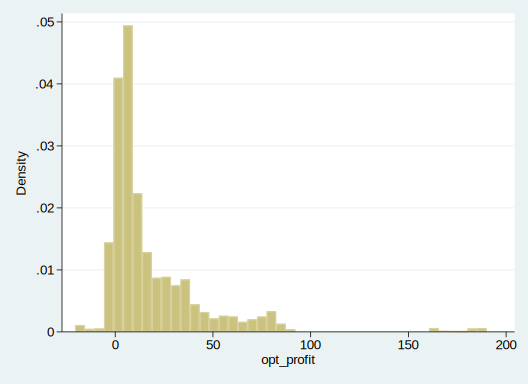

In [69]:
%%stata -d df_analyst_ols -force
est clear
encode ts_code,gen(id)
winsor2 opt_profit, cut(0.5 99.5) by(id) label
histogram opt_profit,  ylabel(, angle(0))

In [97]:
%%stata -d df_analyst_ols -force
est clear
encode ts_code,gen(id)
xtset id time

//缩尾
winsor2 opt_profit, cut(1 99) by(id) label

//分组回归
by id, sort : eststo:  qui reg  opt_profit L.tex_neg  L.total_mv L.pe_ttm_weight L.profit_avg   i.trade_year   ///
if inlist(ts_code ,"000010.SH",  "000300.SH", "000903.SH", "000905.SH","000906.SH", "000985.SH"),r
esttab using Outputs/analyst_sent.doc,star(* 0.1 ** 0.05 *** 0.01) ///
keep(*_neg L.total_mv L.pe_ttm_weight L.profit_avg ) ///
stats(  r2_a N, fmt( %12.2f %12.0f)) ///
title("Table1 Main Market") mtitle("000010.SH" "000300.SH" "000903.SH" "000905.SH" "000906.SH" "000985.SH") ///
long nogap  noeqlines  compress r


. est clear

. encode ts_code,gen(id)

. xtset id time

Panel variable: id (unbalanced)
 Time variable: time, 1 to 2063
         Delta: 1 unit

. 
. //缩尾
. winsor2 opt_profit, cut(1 99) by(id) label

. 
. //分组回归
. by id, sort : eststo:  qui reg  opt_profit L.tex_neg  L.total_mv L.pe_ttm_wei
> ght L.profit_avg   i.trade_year   ///
> if inlist(ts_code ,"000010.SH",  "000300.SH", "000903.SH", "000905.SH","00090
> 6.SH", "000985.SH"),r

-------------------------------------------------------------------------------
-> 000010.SH
(est1 stored)

-------------------------------------------------------------------------------
-> 000015.SH
no observations
no observations

-------------------------------------------------------------------------------
-> 000016.SH
no observations
no observations

-------------------------------------------------------------------------------
-> 000300.SH
(est2 stored)

-------------------------------------------------------------------------------
-> 000903.SH
(

图像情绪影响

In [107]:
%%stata -d df_analyst_ols -force
est clear
encode ts_code,gen(id)
xtset id time

//缩尾
winsor2 opt_profit, cut(1 99) by(id) label

//分组回归
by id, sort : eststo:  qui reg  opt_profit L.img_neg  L.total_mv L.pe_ttm_weight L.profit_avg   i.trade_year   ///
if inlist(ts_code ,"000010.SH",  "000300.SH", "000903.SH", "000905.SH","000906.SH", "000985.SH"),r
esttab using Outputs/analyst_sent_img,star(* 0.1 ** 0.05 *** 0.01) ///
keep(*_neg L.total_mv L.pe_ttm_weight L.profit_avg ) ///
stats(  r2_a N, fmt( %12.2f %12.0f)) ///
title("Table1 Main Market") mtitle("000010.SH" "000300.SH" "000903.SH" "000905.SH" "000906.SH" "000985.SH") ///
long nogap  noeqlines  compress r


. est clear

. encode ts_code,gen(id)

. xtset id time

Panel variable: id (unbalanced)
 Time variable: time, 1 to 2063
         Delta: 1 unit

. 
. //缩尾
. winsor2 opt_profit, cut(1 99) by(id) label

. 
. //分组回归
. by id, sort : eststo:  qui reg  opt_profit L.img_neg  L.total_mv L.pe_ttm_wei
> ght L.profit_avg   i.trade_year   ///
> if inlist(ts_code ,"000010.SH",  "000300.SH", "000903.SH", "000905.SH","00090
> 6.SH", "000985.SH"),r

-------------------------------------------------------------------------------
-> 000010.SH
(est1 stored)

-------------------------------------------------------------------------------
-> 000015.SH
no observations
no observations

-------------------------------------------------------------------------------
-> 000016.SH
no observations
no observations

-------------------------------------------------------------------------------
-> 000300.SH
(est2 stored)

-------------------------------------------------------------------------------
-> 000903.SH
(

绘图

In [101]:
%pystata set graph_size  w 12in h 6in

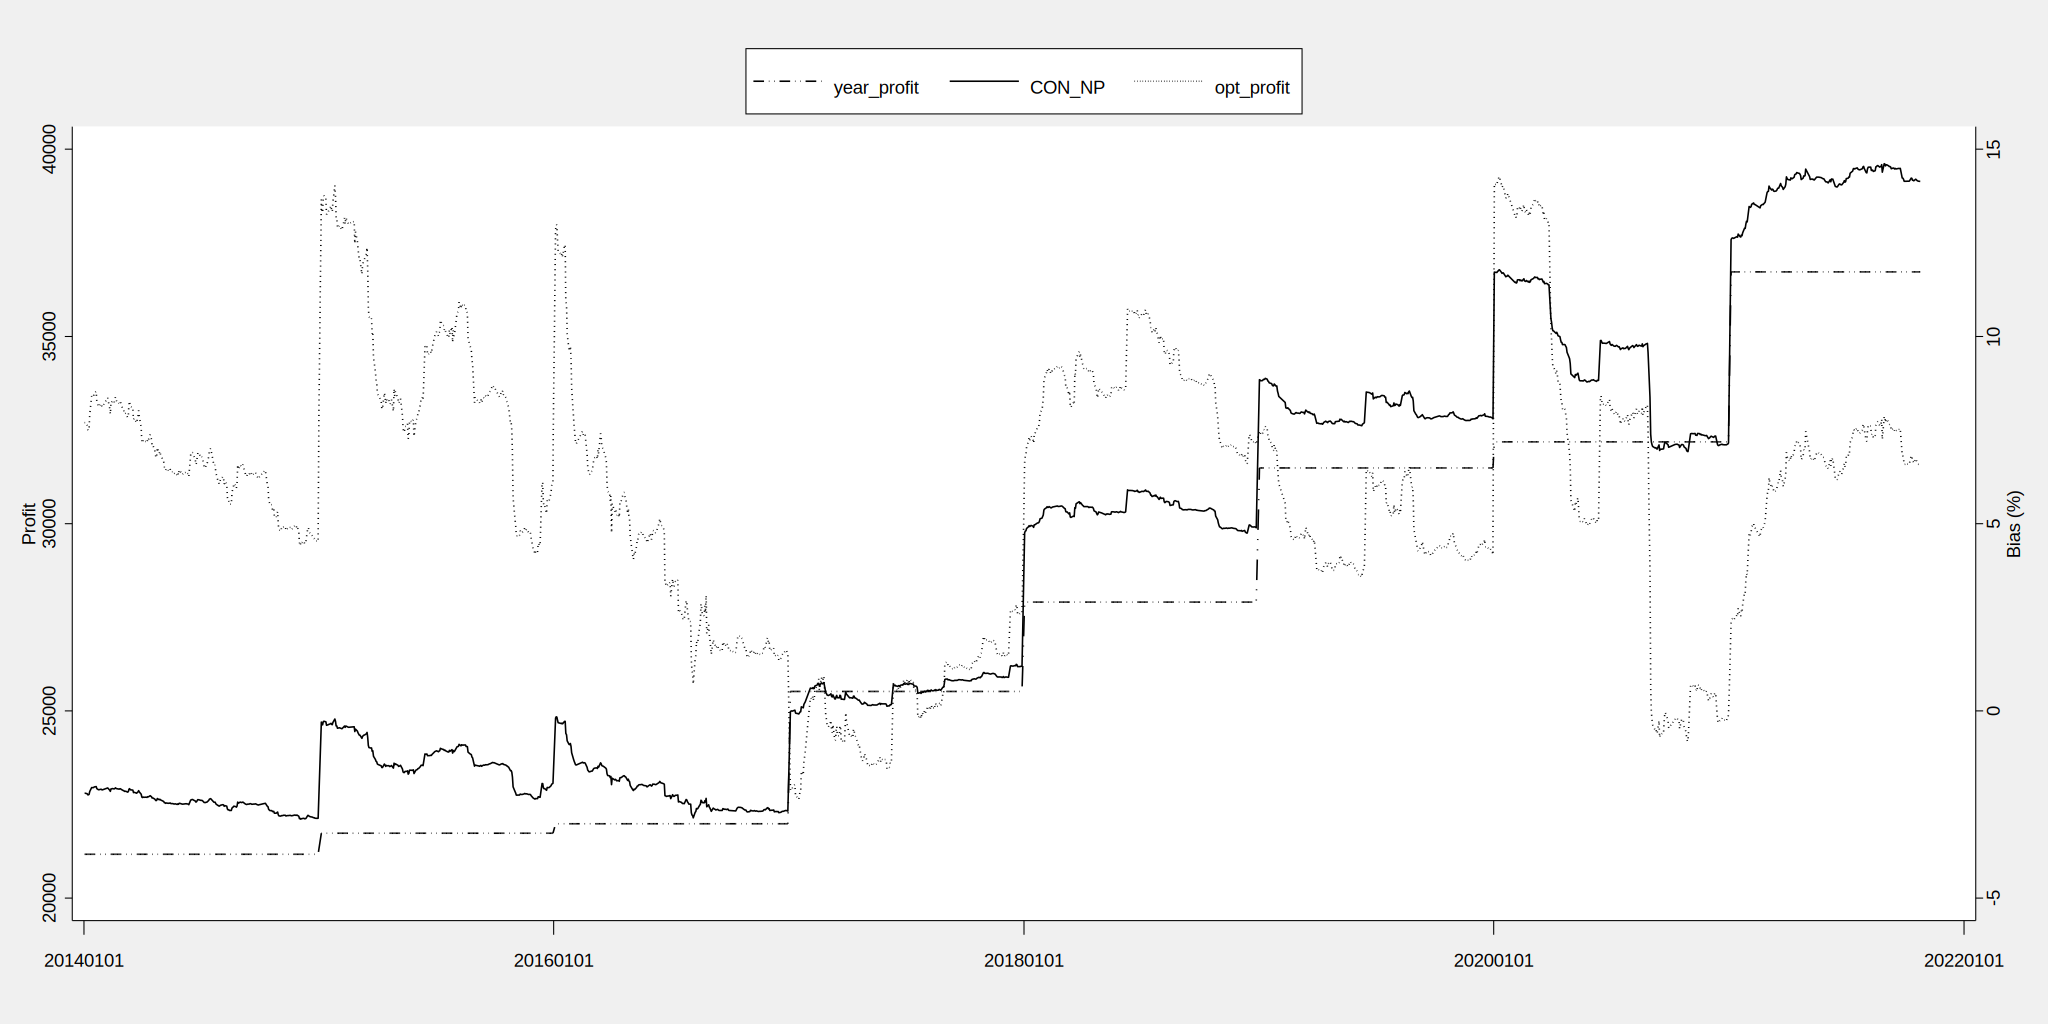

In [102]:
%%stata -d df_analyst_ols -force -qui
encode ts_code,gen(id)
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
xtset id dt

twoway (tsline year_profit, lpattern(dash_dot_dot)) (tsline CON_NP, lpattern(solid)) (tsline opt_profit, yaxis(2) lpattern(tight_dot))  if (ts_code=="000300.SH")&(time<=1900), ytitle(Profit ,axis(1)) ytitle(Bias (%),axis(2))  xtitle("") legend(rows(1) position(12)) scheme(sj) xsize(10)   ylabel(, nogrid)